# DepthAI Tutorial: Training an Object Detection Model with Your Own Data

<img src="https://docs.luxonis.com/images/depthai_logo.png" width="500">

Welcome to DepthAI! 

In this tutorial we will go through the basic training of an object detection model with your own annotated images.

The model you will use is a pretrained Mobilenet SSD v2 from the Tensorflow Object Detection API model zoo. The framework used for training is TensorFlow 1.15.2.
Will run through the following steps:


*   Install the libraries
*   Clone the github repo and replace the repo training data with your data from google drive
    (if you do not have own data, please see this
*   Train the model on the new images
*   Run inference on a few images to see what the model can detect
*   Convert the model to OpenVINO Intermediate Representation
*   To run the model on DepthAI modules, compile the IR obtained above to a .blob file 

You can make a copy of this tutorial: File-> Save a copy in Drive

Note: the model training can be run with the repo images of three fruits if you choose to skip the part with loading your own images






# Install Libraries
# Press Shift+Enter to run cells
Some cells are commented out (all text is green), so they will not run the code inside.
To uncomment code inside a cell, select all the code then press 'Ctrl' + '/'

###After this cell executes runtime will restart to complete the install, ignore and close the message, continue running the cells below this one


In [ ]:
# %%capture
#After this cell executes runtime will restart to finish the install, ignore and close the crash message, continue running cells starting with the one below
!pip install numpy==1.17.5;
import os
os.kill(os.getpid(), 9)

     |████████████████████████████████| 20.0MB 1.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


In [1]:
%tensorflow_version 1.x
!pip install tf_slim

TensorFlow 1.x selected.
     |████████████████████████████████| 358kB 8.9MB/s 


In [2]:
# For the fruit model included in the repo below we have 240 training images
# For faster training time, images should be resized to 300x300 and then annotated
# Images should contain the objects of interest at various scales, angles, lighting conditions, locations
# For acceptable results - mAP@0.5 of 0.9 the model was trained with batch size of 24
# and 5000 steps. this takes about 1h using 2 augmentations. 
# using 5 augmentations it takes about 2h 
num_steps = 5000  # A step means using a single batch of data. larger batch, less steps required
#Number of evaluation steps.
num_eval_steps = 50
#Batch size 24 is a setting that generally works well. can be changed higher or lower 
MODELS_CONFIG = {
        'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 24
    }
}
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colab's GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

## Clone the `object_detection_demo_flow` repository

In [3]:
repo_url = 'https://github.com/GotG/object_detection_demo_flow'
import os
%cd /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'object_detection_demo_flow'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 3035 (delta 0), reused 2 (delta 0), pack-reused 3030
Receiving objects: 100% (3035/3035), 229.09 MiB | 20.42 MiB/s, done.
Resolving deltas: 100% (1372/1372), done.
Checking out files: 100% (2796/2796), done.
/content/object_detection_demo_flow
Already up to date.


#[Optional] If you wish to use your own data, run the cells below.
(Otherwise the model can train with the data already present in the cloned repo)

## Mount your google drive

In [ ]:
#mount your google drive.
#it will be visible in the file navigator on the left of this notebook
#there should be a folder in your drive with your data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Own data should be split into 80% training (train folder), 20% for validation (test folder). The train and test folder should contain images and associated .xml annotations. 

Have extra images for final model testing (final_test folder). These need not be annotated.


In [ ]:
#To train on your own data:
#Remove repo data (images) for training/testing/final testing
!rm -r /content/object_detection_demo_flow/data/images/final_test/
!rm -r /content/object_detection_demo_flow/data/images/train/
!rm -r /content/object_detection_demo_flow/data/images/test/

In [ ]:
#copy files from gdrive to colab drive. this takes a few minutes, depending on the number of files.
#Go on the file explorer on the left of this notebook and access your gdrive. find the folders
#with your train, test and final_test images.
#Right click on each and copy the path. paste it btw the first " " in the corresponding lines  

#training folder
!cp -r "/content/gdrive/My Drive/data/3fruit/train_fruit/" "/content/object_detection_demo_flow/data/images/train"
#testing folder
!cp -r "/content/gdrive/My Drive/data/3fruit/test_fruit/" "/content/object_detection_demo_flow/data/images/test"
#final testing folder
!cp -r "/content/gdrive/My Drive/data/3fruit/final_test_fruit/" "/content/object_detection_demo_flow/data/images/final_test"

In [ ]:
# quick check for training data files. you can also browse to the object_detection_demo_flows
# on the left and see if they were copied
!ls /content/object_detection_demo_flow/data/images/train

apple_10.jpg  apple_55.jpg   banana_32.jpg  banana_76.jpg  orange_32.jpg
apple_10.xml  apple_55.xml   banana_32.xml  banana_76.xml  orange_32.xml
apple_11.jpg  apple_56.jpg   banana_33.jpg  banana_7.jpg   orange_33.jpg
apple_11.xml  apple_56.xml   banana_33.xml  banana_7.xml   orange_33.xml
apple_12.jpg  apple_57.jpg   banana_34.jpg  banana_8.jpg   orange_34.jpg
apple_12.xml  apple_57.xml   banana_34.xml  banana_8.xml   orange_34.xml
apple_13.jpg  apple_58.jpg   banana_35.jpg  banana_9.jpg   orange_35.jpg
apple_13.xml  apple_58.xml   banana_35.xml  banana_9.xml   orange_35.xml
apple_14.jpg  apple_59.jpg   banana_36.jpg  mixed_10.jpg   orange_36.jpg
apple_14.xml  apple_59.xml   banana_36.xml  mixed_10.xml   orange_36.xml
apple_15.jpg  apple_5.jpg    banana_37.jpg  mixed_11.jpg   orange_37.jpg
apple_15.xml  apple_5.xml    banana_37.xml  mixed_11.xml   orange_37.xml
apple_16.jpg  apple_60.jpg   banana_38.jpg  mixed_12.jpg   orange_38.jpg
apple_16.xml  apple_60.xml   banana_38.xml  mixed_1

# Install Tensorflow Object Detection API

Clone TF models which contains the Object Detection API; also install the required dependencies


In [4]:
# %%capture
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git
%cd /content/models/
!git checkout 58d19c67e1d30d905dd5c6e5092348658fed80af
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk
!pip install -q Cython contextlib2 pillow lxml matplotlib
!pip install -q pycocotools
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.
import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'
!python object_detection/builders/model_builder_test.py

/content
/content/models
Note: checking out '58d19c67e1d30d905dd5c6e5092348658fed80af'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 58d19c67 Internal change
Selecting previously unselected package python-bs4.
(Reading database ... 144676 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack

## Prepare `tfrecord` files



In [5]:
%%capture
%cd {repo_dir_path}

# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
!python xml_to_csv.py -i data/images/train -o data/annotations/train_labels.csv -l data/annotations

# Convert test folder annotation xml files to a single csv.
!python xml_to_csv.py -i data/images/test -o data/annotations/test_labels.csv

# Generate `train.record`
!python generate_tfrecord.py --csv_input=data/annotations/train_labels.csv --output_path=data/annotations/train.record --img_path=data/images/train --label_map data/annotations/label_map.pbtxt

# Generate `test.record`
!python generate_tfrecord.py --csv_input=data/annotations/test_labels.csv --output_path=data/annotations/test.record --img_path=data/images/test --label_map data/annotations/label_map.pbtxt

# Set the paths
test_record_fname = '/content/object_detection_demo_flow/data/annotations/test.record'
train_record_fname = '/content/object_detection_demo_flow/data/annotations/train.record'
label_map_pbtxt_fname = '/content/object_detection_demo_flow/data/annotations/label_map.pbtxt'

## Download the Mobilenet SSD v2 Model

In [6]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research
/content/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 63 root   root  4.0K Sep 18 06:43 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model


In [7]:
#TF pretrained model checkpoint
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [8]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [9]:
import re
iou_threshold = 0.50
num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    # Set number of classes num_classes.
    s = re.sub('iou_threshold: [0-9].[0-9]+',
               'iou_threshold: {}'.format(iou_threshold), s)
    
    f.write(s)

In [ ]:
# #Have a look at the config file with various settings
# !cat {pipeline_fname}

# Train the model

##[Optional] The cell below adds Tensorboard visualization to the training process.
Will open in new tab.

In [ ]:
#After running this cell click on the link in the output cell to open tensorboard
#Tensoarboard will show you graphically different training parameters as the model is training
#when training finishes after the set number of steps, tensorboard can be used to see a nice summary of the training process
#Visuals will load in Tensorboard after the model has gone through a few hundred steps

model_dir = 'training/'
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-06-10 15:27:48--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.203.87.192, 52.22.244.167, 54.164.74.108, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.203.87.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  16.5MB/s    in 0.8s    

2020-06-10 15:27:49 (16.5 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://104d39912cce.ngrok.io


## Start the training

In [10]:
model_dir = 'training/'
# Optionally remove content in output model directory for a fresh start.
# !rm -rf {model_dir}
# os.makedirs(model_dir, exist_ok=True)
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

W0918 06:44:30.172804 139841791674240 model_lib.py:717] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 5000
I0918 06:44:30.173022 139841791674240 config_util.py:552] Maybe overwriting train_steps: 5000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0918 06:44:30.173126 139841791674240 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0918 06:44:30.173215 139841791674240 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0918 06:44:30.173311 139841791674240 config_util.py:552] Maybe overwriting eval_num_epochs: 1
INFO:tensorflow:Maybe overwriting load_pretrained: True
I0918 06:44:30.173395 139841791674240 config_util.py:552] Maybe overwriting load_pretrained: True
INFO:tensorflow:Ignoring config override key: load_pretrained
I0918 06:44:30.173475 139841791674240 config_util.py:5

In [11]:
#model dir check for the trained model
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1600411490.ded445c31f48
export
graph.pbtxt
model.ckpt-0.data-00000-of-00001
model.ckpt-0.index
model.ckpt-0.meta
model.ckpt-1329.data-00000-of-00001
model.ckpt-1329.index
model.ckpt-1329.meta
model.ckpt-2710.data-00000-of-00001
model.ckpt-2710.index
model.ckpt-2710.meta
model.ckpt-4108.data-00000-of-00001
model.ckpt-4108.index
model.ckpt-4108.meta
model.ckpt-5000.data-00000-of-00001
model.ckpt-5000.index
model.ckpt-5000.meta


## Export a Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [12]:
#clean output_directory if necessary to start fresh:

# !rm -rf /content/object_detection_demo/fine_tuned_model/ 
# os.makedirs('/content/object_detection_demo_flow/fine_tuned_model/', exist_ok=True)

In [13]:
%%capture
import re
import numpy as np

output_directory = './fine_tuned_model'
# output_directory = '/content/gdrive/My\ Drive/data/'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

In [ ]:
#export directory check
# !ls {output_directory}

In [14]:
import os
pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)
# !ls -alh {pb_fname}

## Running Inference: Checking what the trained model can detect
Test with images in repository `object_detection_demo_flow/data/images/final test` directory.

In [15]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "data/images/final_test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/object_detection_demo_flow/data/images/final_test/banana_79.jpg', '/content/object_detection_demo_flow/data/images/final_test/banana_80.jpg', '/content/object_detection_demo_flow/data/images/final_test/banana_77.jpg', '/content/object_detection_demo_flow/data/images/final_test/orange_77.jpg', '/content/object_detection_demo_flow/data/images/final_test/banana_78.jpg', '/content/object_detection_demo_flow/data/images/final_test/mixed_24.jpg', '/content/object_detection_demo_flow/data/images/final_test/mixed_21.jpg', '/content/object_detection_demo_flow/data/images/final_test/apple_93.jpg', '/content/object_detection_demo_flow/data/images/final_test/mixed_22.jpg', '/content/object_detection_demo_flow/data/images/final_test/orange_82.jpg', '/content/object_detection_demo_flow/data/images/final_test/banana_81.jpg', '/content/object_detection_demo_flow/data/images/final_test/orange_81.jpg', '/content/object_detection_demo_flow/data/images/final_test/apple_90.jpg', '/content/object

/content/models/research/object_detection
/content/object_detection_demo_flow/data/images/final_test/banana_79.jpg


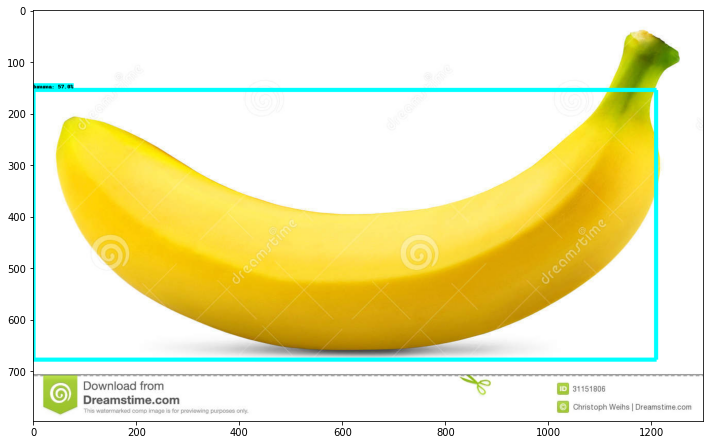

/content/object_detection_demo_flow/data/images/final_test/banana_80.jpg


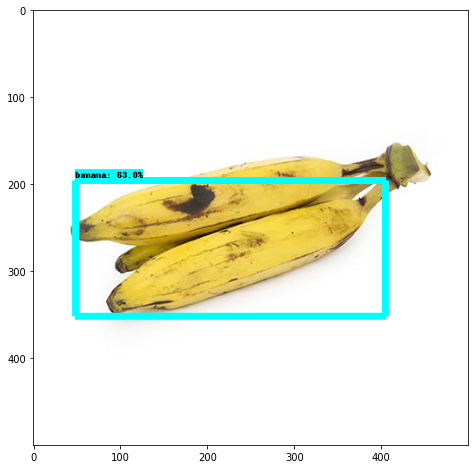

/content/object_detection_demo_flow/data/images/final_test/banana_77.jpg


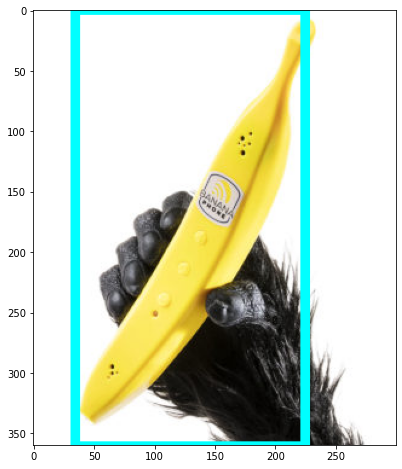

/content/object_detection_demo_flow/data/images/final_test/orange_77.jpg


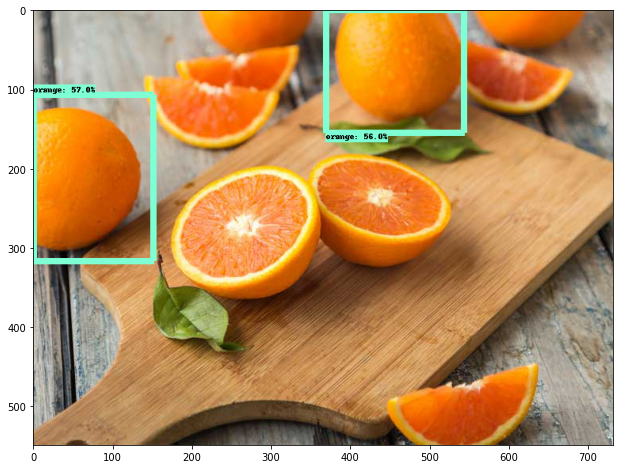

/content/object_detection_demo_flow/data/images/final_test/banana_78.jpg


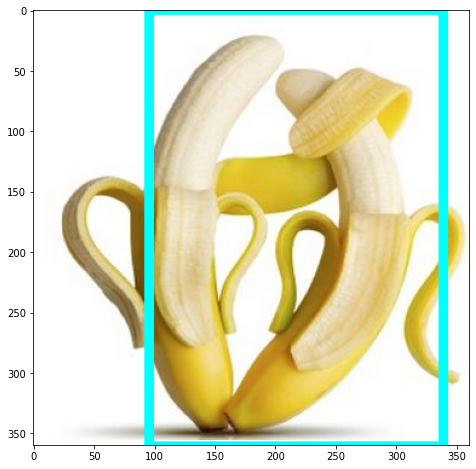

/content/object_detection_demo_flow/data/images/final_test/mixed_24.jpg


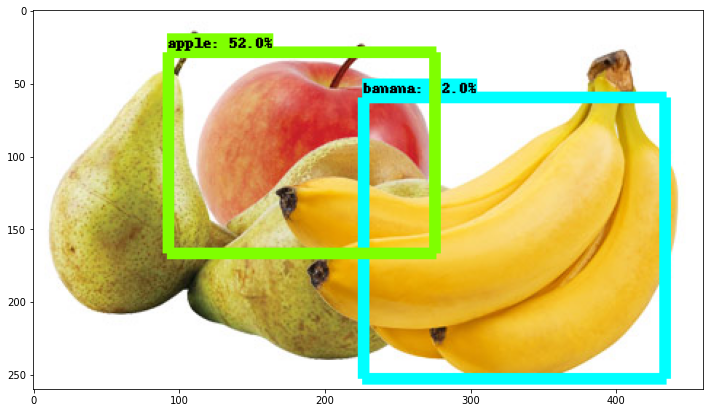

/content/object_detection_demo_flow/data/images/final_test/mixed_21.jpg


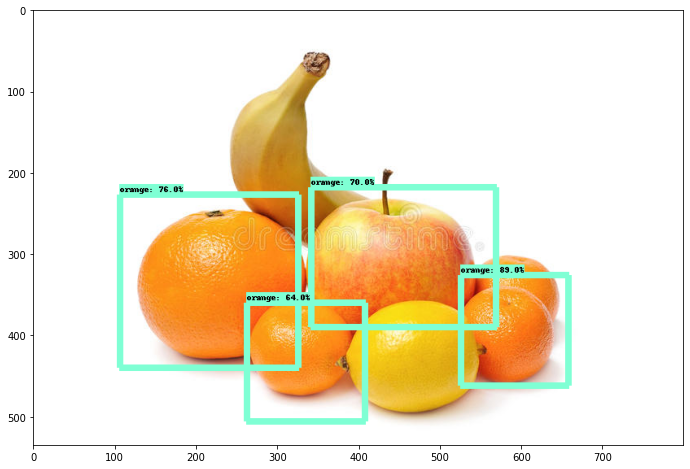

/content/object_detection_demo_flow/data/images/final_test/apple_93.jpg


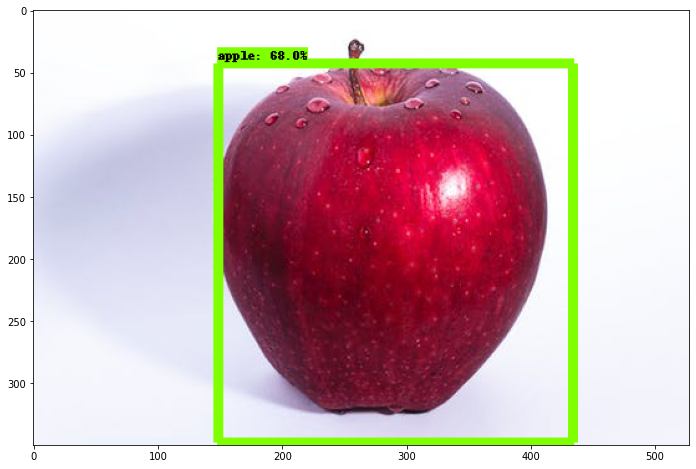

/content/object_detection_demo_flow/data/images/final_test/mixed_22.jpg


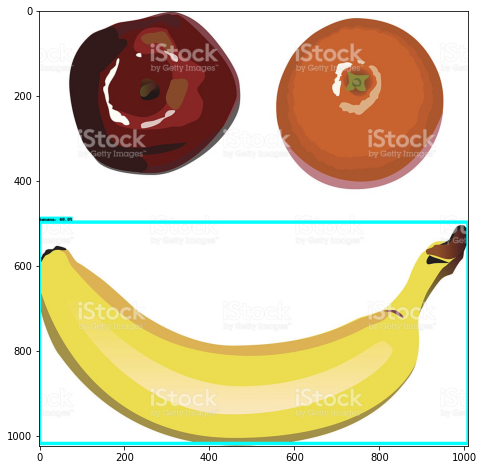

/content/object_detection_demo_flow/data/images/final_test/orange_82.jpg


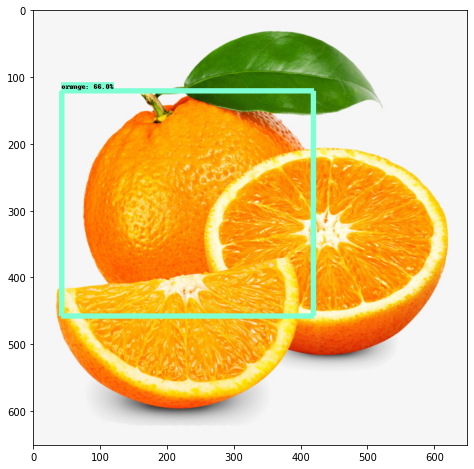

/content/object_detection_demo_flow/data/images/final_test/banana_81.jpg


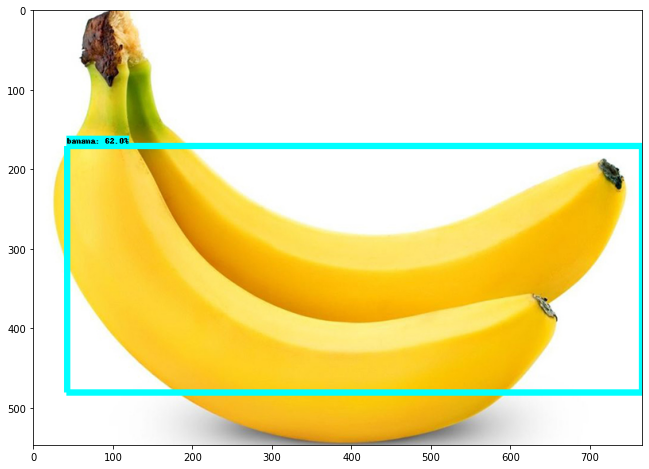

/content/object_detection_demo_flow/data/images/final_test/orange_81.jpg


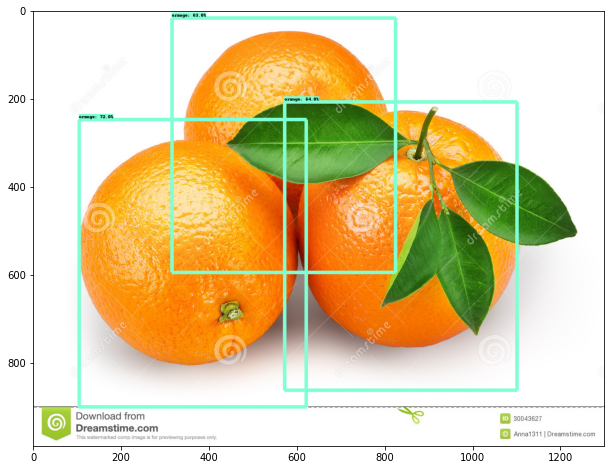

/content/object_detection_demo_flow/data/images/final_test/apple_90.jpg


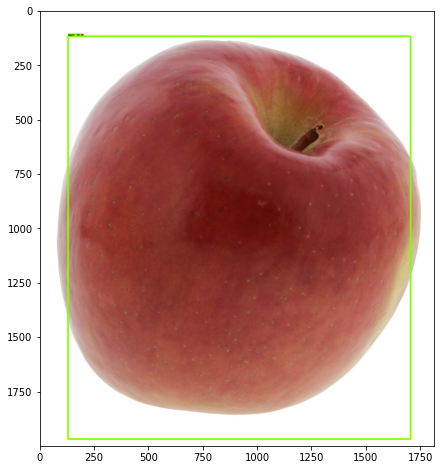

/content/object_detection_demo_flow/data/images/final_test/mixed_23.jpg


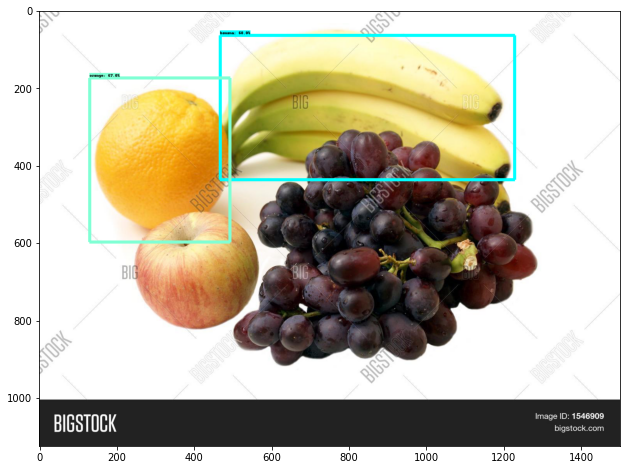

/content/object_detection_demo_flow/data/images/final_test/apple_94.jpg


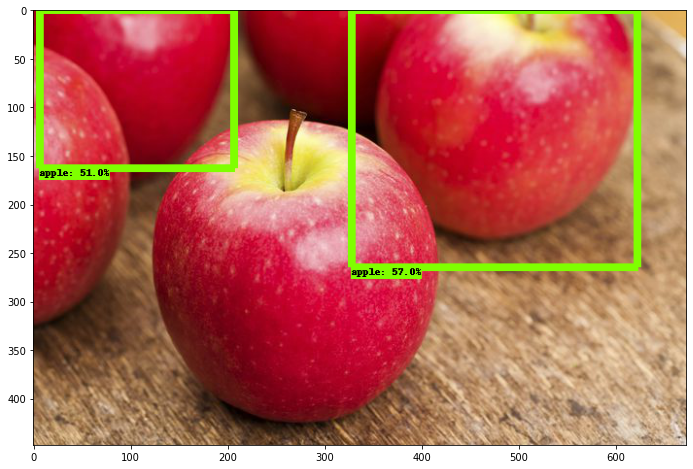

/content/object_detection_demo_flow/data/images/final_test/apple_91.jpg


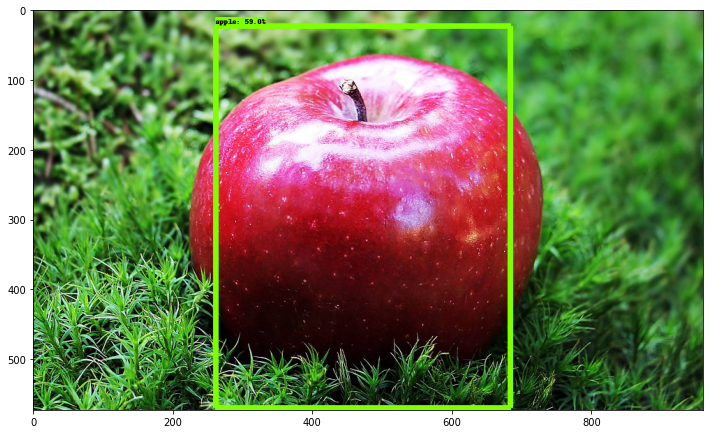

/content/object_detection_demo_flow/data/images/final_test/banana_82.jpg


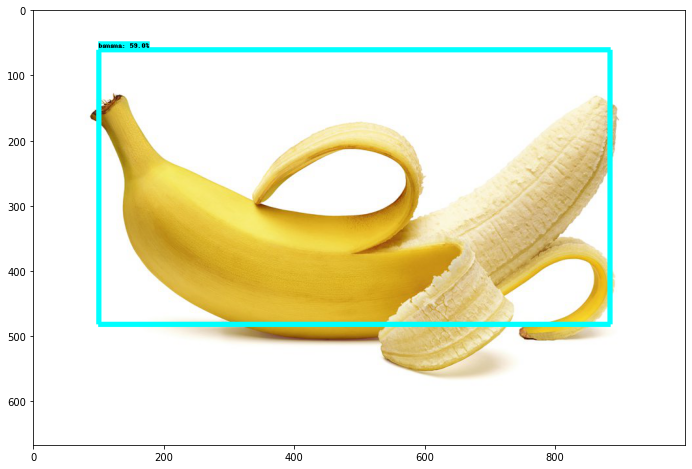

In [17]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
# This is needed to display the images.
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    print(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    plt.show()

# Convert TF model to OpenVINO 20.01 Intermediate Representation (IR)
 This can be used to run inference on OpenVINO.
# In order to run the model on DepthAI modules, we then compile the IR obtained above to a .blob (via a server we set up just for that) 

## First, we install Open Vino 20.01


In [18]:
%cd ../..

/content/models


In [21]:
%%time
# %%capture
## install tools. Open Vino takes some time to download: 10-15 min sometimes.
!sudo apt-get install -y pciutils cpio
!sudo apt autoremove
## downnload installation files
!wget http://registrationcenter-download.intel.com/akdlm/irc_nas/16345/l_openvino_toolkit_p_2020.1.023.tgz
path = "l_openvino_toolkit_p_2020.1.023.tgz"
# path = "/content/software/Intel OpenVINO 2019 R3.1/l_openvino_toolkit_p_2019.3.376.tgz"
## install openvino
!tar xf "{path}"
# !tar xf "{path}" && \
#     cd l_openvino_toolkit_p* && \
#     ./install_openvino_dependencies.sh && \
#     sed -i 's/decline/accept/g' silent.cfg && \
#     ./install.sh
# ## install dependencies
# !/opt/intel/openvino/install_dependencies/install_openvino_dependencies.sh
# ## install prerequisites
# !/opt/intel/openvino/deployment_tools/model_optimizer/install_prerequisites/install_prerequisites.sh

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cpio is already the newest version (2.12+dfsg-6ubuntu0.18.04.1).
pciutils is already the newest version (1:3.5.2-1ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
--2020-09-18 07:31:01--  http://registrationcenter-download.intel.com/akdlm/irc_nas/16345/l_openvino_toolkit_p_2020.1.023.tgz
Resolving registrationcenter-download.intel.com (registrationcenter-download.intel.com)... 88.221.164.5
Connecting to registrationcenter-download.intel.com (registrationcenter-download.intel.com)|88.221.164.5|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 508213676 (485M) [application/x-compressed]
Saving to: ‘l_openvino_toolkit_p_2020.1.023.tgz.1’

l_openvino_toolkit_ 100%[===================>] 484

In [22]:
%%capture
%cd l_openvino_toolkit_p_2020.1.023/
!./install_openvino_dependencies.sh && \
    sed -i 's/decline/accept/g' silent.cfg && \
    ./install.sh --silent silent.cfg

In [23]:
!ls

EULA.txt	install_openvino_dependencies.sh  pset		  rpm
install_GUI.sh	install.sh			  PUBLIC_KEY.PUB  silent.cfg


[Optional] Open Vino install check, generally not needed

In [ ]:
# !source /opt/intel/openvino/bin/setupvars.sh && \
#     /opt/intel/openvino/deployment_tools/demo/demo_squeezenet_download_convert_run.sh

### Here we run some modifications in the ssd2 OpenVINO extension for TF so that our Mobilenet SSDv2 model can convert successfully to the IR

In [24]:
%cd /opt/intel/openvino/deployment_tools/model_optimizer/extensions/front/tf/
#openvino fixes: edit 
# Read in the file, make sure the .json corresponds to the model!!!
with open('ssd_v2_support.json', 'r') as file :
  filedata = file.read()

# Replace the target string
filedata = filedata.replace('"Postprocessor/ToFloat"', '"Postprocessor/Cast_1"')

# Write the file out again
with open('ssd_v2_support.json', 'w') as file:
  file.write(filedata)


/opt/intel/openvino_2020.1.023/deployment_tools/model_optimizer/extensions/front/tf


## Convert TF model to Open Vino Intermediate Representation
If using own model, please change to your desired name for output directory --output_dir "choose name"

In [26]:
#CONVERT TF MODEL to OPEN VINO IRv10. saved in IR_V10_fruits_mnssdv2_6k directory or
#choose own name for --output_dir "choose name"
%cd "/content/models/research/fine_tuned_model/"
!source /opt/intel/openvino/bin/setupvars.sh && \
    python /opt/intel/openvino/deployment_tools/model_optimizer/mo.py \
    --input_model frozen_inference_graph.pb \
    --tensorflow_use_custom_operations_config /opt/intel/openvino/deployment_tools/model_optimizer/extensions/front/tf/ssd_v2_support.json \
    --tensorflow_object_detection_api_pipeline_config pipeline.config \
    --reverse_input_channels \
    --output_dir fruits_5k \
    --data_type FP16

/content/models/research/fine_tuned_model
[setupvars.sh] OpenVINO environment initialized
[ WARNING ]  Use of deprecated cli option --tensorflow_use_custom_operations_config detected. Option use in the following releases will be fatal. Please use --transformations_config cli option instead
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/content/models/research/fine_tuned_model/frozen_inference_graph.pb
	- Path for generated IR: 	/content/models/research/fine_tuned_model/fruits_5k
	- IR output name: 	frozen_inference_graph
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#check directory containing the exported TF trained model and the IRv10 folder
%ls 

## Now we compile the IR model to a .blob for use on DepthAI modules/platform

---



### We save the blob in the IR directory from above, corresponding to --output_dir parameter above. 
The blob filename will be *frozen_inference_graph.blob*

In [27]:
#No changes needed here unless using custom data.
#CHOOSE the directory where you would like to save the blob.
# I use the same --output_dir as above for the IR conversion
blob_dir = "/content/models/research/fine_tuned_model/fruits_5k/"

#Copy the path of your .xml and .bin files. For that, you can look at the IR
#conversion output cell, select and copy from:
#[SUCCESS] XML file and bin file paths.
#Or you can choose to compile other .xml .bin files from a different location
#
xmlfile = "/content/models/research/fine_tuned_model/fruits_5k/frozen_inference_graph.xml"
binfile = "/content/models/research/fine_tuned_model/fruits_5k/frozen_inference_graph.bin"

import requests

#For openvino 20.01 use this link to compile the blob
url = "http://69.164.214.171:8080"


#open vino 20.02 link:
# url = "69.164.214.171:8081"

payload = {'compiler_params': '-ip U8 -VPU_MYRIAD_PLATFORM VPU_MYRIAD_2480 -VPU_NUMBER_OF_SHAVES 4 -VPU_NUMBER_OF_CMX_SLICES 4'}
files = [
  ('definition', open(xmlfile,'rb')),
  ('weights', open(binfile,'rb'))
]
# headers = {
#   'Content-Type': 'application/json'
# }
response = requests.request("POST", url, data = payload, files = files)
blobnameraw = response.headers.get('Content-Disposition')
print(blobnameraw)
blobname = blobnameraw[blobnameraw.find('='):][1:]
with open(blob_dir + blobname, 'wb') as f:
  f.write(response.content)

attachment; filename=frozen_inference_graph.blob


##Now you can download your .blob file and run it on the DepthAI module/platform
To download locally, use the file explorer on the left to locate the file in the --output_dir folder, then right click download. Colab takes a few seconds to prepare the file, then the download prompt will appear.

## To run the .blob in DepthAI, follow step 5 here:
 https://docs.luxonis.com/tutorials/object_det_mnssv2_training/

##[Optional] to convert the blob locally, download the IR files .bin and .xml and follow these instructions: https://github.com/luxonis/depthai#conversion-of-existing-trained-models-into-intel-movidius-binary-format

In [ ]:
#Compress the folder with the Tensorflow model and OpenVINO IR_V10 folder and download it locally.
#These are in content/models/research/fine_tuned_model, so we compress the fine_tuned_model folder.
%cd /content/models/research/
!tar cvf fine_tuned_model.tar.gz fine_tuned_model


/content/models/research
fine_tuned_model/
fine_tuned_model/saved_model/
fine_tuned_model/saved_model/saved_model.pb
fine_tuned_model/saved_model/variables/
fine_tuned_model/model.ckpt.index
fine_tuned_model/fine_tuned_model.tar.gz
fine_tuned_model/pipeline.config
fine_tuned_model/checkpoint
fine_tuned_model/IR_V10_fruits_mnssdv2_6k/
fine_tuned_model/model.ckpt.meta
fine_tuned_model/model.ckpt.data-00000-of-00001
fine_tuned_model/frozen_inference_graph.pb


In [ ]:
#download the compressed IRv10 folder locally
#or can use file navigator on the left to move it to your gdrive
from google.colab import files
files.download("fine_tuned_model.tar.gz")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>